### Import Packages

In [269]:
import os
import pandas as pd
import polars as pl
import numpy as np
from pathlib import Path

## Phase 1: Dataset Selection and Preprocessing

In [270]:
projectdir = Path(os.getcwd())
datadir = projectdir.parent / 'Dataset'
shopping_data = pd.read_csv('e-shop clothing 2008.csv', delimiter=';')

In [271]:
shopping_data.head(3)

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1


In [272]:
shopping_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165464 entries, 0 to 165463
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   year                     165464 non-null  int64 
 1   month                    165464 non-null  int64 
 2   day                      165464 non-null  int64 
 3   order                    165464 non-null  int64 
 4   country                  165464 non-null  int64 
 5   session ID               165464 non-null  int64 
 6   page 1 (main category)   165464 non-null  int64 
 7   page 2 (clothing model)  165464 non-null  object
 8   colour                   165464 non-null  int64 
 9   location                 165464 non-null  int64 
 10  model photography        165464 non-null  int64 
 11  price                    165464 non-null  int64 
 12  price 2                  165464 non-null  int64 
 13  page                     165464 non-null  int64 
dtypes: int64(13), object

#### Rename columns

In [273]:
shopping_data.rename(columns={
    'session ID': 'session-id',
    'price 2': 'price-higher-than-category',
    'page 1 (main category)': 'category',
    'page 2 (clothing model)': 'product-code',
    'model photography': 'model-photography',
    'page': 'page-no'
}, inplace=True)

#### Data Encoding

In [274]:
shopping_data['price-higher-than-category'] = shopping_data['price-higher-than-category'].apply(lambda x: 1 if x == 1 else 0)

In [275]:
class LabelEncoder:
    def __init__(self) -> None:
        self.str2idx = {}
        self.idx2str = {}
    
    def __str__(self) -> str:
        return f'Number of encoded strings: {len(self.str2idx)}'
    
    def __repr__(self) -> str:
        return self.__str__()
    
    def fit(self, col: np.array) -> None:
        c = 0
        for strItem in col:
            if strItem not in self.str2idx:
                self.str2idx[strItem] = c
                self.idx2str[c] = strItem
                c += 1

    def transform(self, col: np.array) -> np.array:
        return np.array([self.str2idx[ele] for ele in col])
    
    def inverse_transform(self, col: np.array) -> np.array:
        return np.array([self.idx2str[ele] for ele in col])
    
    def fit_transform(self, col: np.array) -> np.array:
        self.fit(col)
        return self.transform(col)

In [276]:
product_encoder = LabelEncoder()
shopping_data['product-code-en'] = product_encoder.fit_transform(shopping_data['product-code'])

In [277]:
def price_bucketing(price: int):
    if price in range(0, 26):
        return 'budget'
    elif price in range(26, 36):
        return 'value'
    elif price in range(35, 66):
        return 'average'
    elif price in range(66, 101):
        return 'premium'
    else:
        return None

shopping_data['price-category'] = shopping_data['price'].apply(lambda price: price_bucketing(price))

In [278]:
price_category_encoder = LabelEncoder()
shopping_data['price-category_en'] = price_category_encoder.fit_transform(shopping_data['price-category'])

In [279]:
shopping_data.drop(['price-category', 'product-code'], axis=1, inplace=True)

In [280]:
shopping_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165464 entries, 0 to 165463
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   year                        165464 non-null  int64
 1   month                       165464 non-null  int64
 2   day                         165464 non-null  int64
 3   order                       165464 non-null  int64
 4   country                     165464 non-null  int64
 5   session-id                  165464 non-null  int64
 6   category                    165464 non-null  int64
 7   colour                      165464 non-null  int64
 8   location                    165464 non-null  int64
 9   model-photography           165464 non-null  int64
 10  price                       165464 non-null  int64
 11  price-higher-than-category  165464 non-null  int64
 12  page-no                     165464 non-null  int64
 13  product-code-en             165464 non-null 

#### Missing values

In [281]:
shopping_data.isna().sum()

year                          0
month                         0
day                           0
order                         0
country                       0
session-id                    0
category                      0
colour                        0
location                      0
model-photography             0
price                         0
price-higher-than-category    0
page-no                       0
product-code-en               0
price-category_en             0
dtype: int64

Retrieving from S3 public dataset bucket

In [282]:
shopping_data.head(10)

,year,month,day,order,country,session-id,category,colour,location,model-photography,price,price-higher-than-category,page-no,product-code-en,price-category_en
0,2008,4,1,1,29,1,1,1,5,1,28,0,1,0,0
1,2008,4,1,2,29,1,1,1,6,1,33,0,1,1,0
2,2008,4,1,3,29,1,2,10,2,1,52,1,1,2,1
3,2008,4,1,4,29,1,2,6,6,2,38,0,1,3,1
4,2008,4,1,5,29,1,2,4,3,2,52,1,1,4,1
5,2008,4,1,6,29,1,3,6,1,2,57,1,4,5,1
6,2008,4,1,7,29,1,3,5,1,2,33,0,4,6,0
7,2008,4,1,8,29,1,4,9,5,1,38,1,4,7,1
8,2008,4,1,9,29,1,4,6,4,2,48,1,5,8,1
9,2008,4,1,1,29,2,2,9,5,1,57,1,2,9,1


### Get Data

In [283]:
!pip install calplot

### Import Packages

In [284]:
import calplot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.express as px
from sklearn.model_selection import train_test_split

### Data Exploration & Visualisation

In [285]:
classification_data = shopping_data.drop(['price'], axis=1)
regression_data = shopping_data.drop(['price-category_en'], axis=1)

#### Univariate Analysis

Checking out year ranges present in the data

In [286]:
shopping_data['year'].value_counts()

2008    165464
Name: year, dtype: int64

The year attribute only has one value - `2008`. Hence does not give any unique information about the response variable. Thereby can be dropped!

Checking out unique session ids

In [287]:
print(f'Unique Session IDs: {len(shopping_data["session-id"].unique())}')

Unique Session IDs: 24023


Session IDs are techincally unique IDs for each new user session that is generated. Hence this ID doesn't tell us anything about user's behaviour.

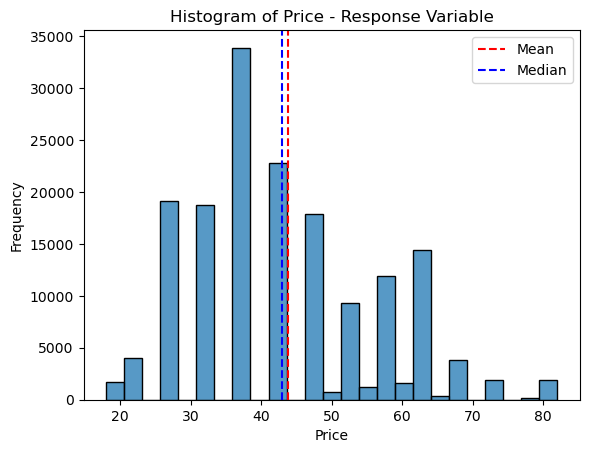

In [288]:
sns.histplot(shopping_data['price'], bins=25)
plt.axvline(x=shopping_data['price'].mean(), label='Mean', color='red', linestyle='--')
plt.axvline(x=shopping_data['price'].median(), label='Median', color='blue', linestyle='--')
plt.title(f'Histogram of Price - Response Variable')
plt.xlabel(f'Price')
plt.ylabel(f'Frequency')
plt.legend()
plt.show()

Mean pricing is about 44 & Median is about 43

Checking months with highest & lowest orders

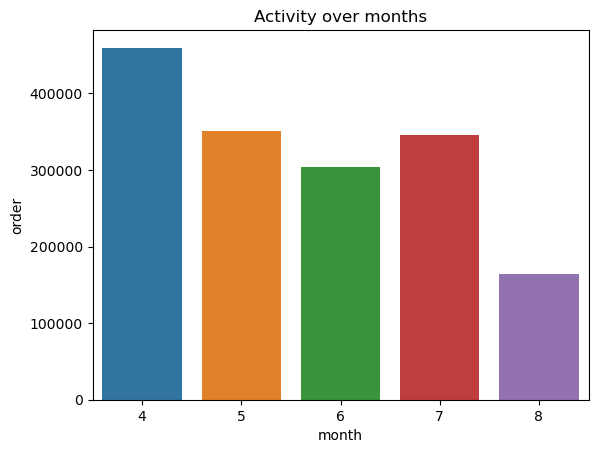

In [289]:
monthly_activity = shopping_data.groupby(['month'])['order'].sum().reset_index()
sns.barplot(x=monthly_activity['month'], y=monthly_activity['order'])
plt.title(f'Activity over months')
plt.show()

Visualising calender heatmap to understand temporal changes in number of orders, throughout the year

In [290]:
dates = shopping_data['day'].astype('str') + '/' + shopping_data['month'].astype('str') + '/' + shopping_data['year'].astype('str')
shopping_data['date'] = pd.to_datetime(dates, dayfirst=True)

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


<Figure size 1000x1000 with 0 Axes>

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


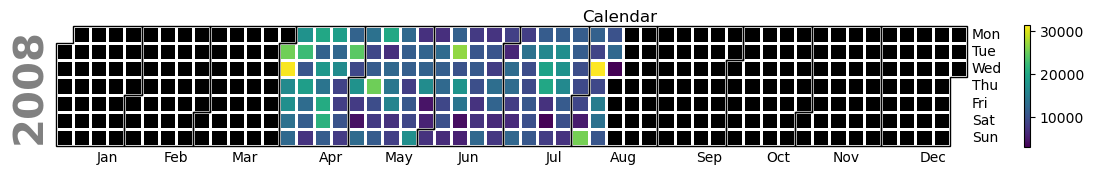

In [291]:
values = shopping_data.groupby(['date'])['order'].sum()

plt.figure(figsize=(10,10))
calplot.calplot(values,
                suptitle = 'Calendar',
                suptitle_kws = {'x': 0.5, 'y': 1.0}, fillcolor = 'black', edgecolor = 'black')
plt.show()

Clearly, the dates with lighter colors have highest number of orderes recieved. Rest seem to be recieve average number of orders. The dates with black or darker shades of green / blue have minimum number of orders. The following is observed:
- April has major number of orders (More lighter color cells)
- June has lowest amount of orders recieved
- May & July almost have equal amounts of orders recieved.
- Aug has one day with very high amounts of orderes recieved.

Finding the countries with most orders

In [292]:
country_map = {
    1:'Australia', 2:'Austria', 3:'Belgium',
    4:'British Virgin Islands', 5:'Cayman Islands',
    6:'Christmas Island', 7:'Croatia', 8:'Cyprus',
    9:'Czech Republic', 10:'Denmark', 11:'Estonia',
    12:'unidentified', 13:'Faroe Islands', 14:'Finland',
    15:'France', 16:'Germany', 17:'Greece',
    18:'Hungary', 19:'Iceland', 20:'India', 21:'Ireland',
    22:'Italy', 23:'Latvia', 24:'Lithuania', 25:'Luxembourg',
    26:'Mexico', 27:'Netherlands', 28:'Norway', 29:'Poland',
    30:'Portugal', 31:'Romania', 32:'Russia', 33:'San Marino',
    34:'Slovakia', 35:'Slovenia', 36:'Spain', 37:'Sweden',
    38:'Switzerland', 39:'Ukraine', 40:'United Arab Emirates',
    41:'United Kingdom', 42:'USA'
}

In [293]:
geodata = shopping_data[['country', 'order']]
geodata['country_name'] = geodata['country'].apply(lambda c: country_map.get(c))

C:\Users\BharathRajPragada\AppData\Local\Temp\ipykernel_16680\1199770497.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



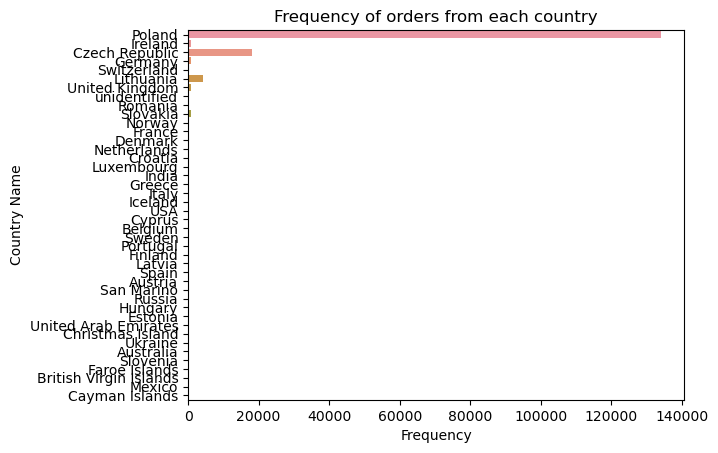

In [294]:
sns.countplot(geodata, y='country_name')
plt.title(f'Frequency of orders from each country')
plt.xlabel('Frequency')
plt.ylabel('Country Name')
plt.show()

Clearly, countries like Poland, Czech Republic, and Lithuania have highest frequency of orders.<br><br>We shall remove these countries of very high frequency and check the order frequency from other countries.

In [295]:
database = px.data.gapminder().query('year == 2007')[['country', 'iso_alpha', 'iso_num']]
geodata_en = pd.merge(database, geodata, how='inner', left_on='country', right_on='country_name')
geodata_en.drop(['country_x', 'country_y'], axis=1, inplace=True)
geodata_en = geodata_en.groupby(['country_name', 'iso_alpha', 'iso_num']).sum().reset_index()

In [296]:
countries_to_remove = ['Poland', 'Czech Republic']
geodata_en = geodata_en[~geodata_en['country_name'].isin(countries_to_remove)]

In [297]:
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)

fig = px.choropleth(geodata_en,
                    locations="country_name",#"iso_alpha",
                    locationmode="country names",#"ISO-3",
                    geojson = f"{url}/world-countries.json",
                    color="order", title='Countrywise order count'
                   )

fig.show()

Users from Germany, UK, Ireland, Norway, and Romania have placed high amount of orders when compared to the rest of the countries

In [298]:
geodata = shopping_data[['country', 'price']]
geodata['country_name'] = geodata['country'].apply(lambda c: country_map.get(c))
database = px.data.gapminder().query('year == 2007')[['country', 'iso_alpha', 'iso_num']]
geodata_en = pd.merge(database, geodata, how='inner', left_on='country', right_on='country_name')
geodata_en.drop(['country_x', 'country_y'], axis=1, inplace=True)
geodata_en = geodata_en.groupby(['country_name', 'iso_alpha', 'iso_num']).sum().reset_index()
countries_to_remove = ['Poland', 'Czech Republic']
geodata_en = geodata_en[~geodata_en['country_name'].isin(countries_to_remove)]

url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)

fig = px.choropleth(geodata_en,
                    locations="country_name",#"iso_alpha",
                    locationmode="country names",#"ISO-3",
                    geojson = f"{url}/world-countries.json",
                    color="price", title='Price contribution from each country'
                   )

fig.show()

C:\Users\BharathRajPragada\AppData\Local\Temp\ipykernel_16680\2861233402.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Germany, Ireland, UK, France, Sweden, Norway, and Romania have placed high value orders next to Poland & Czech Republic.

### Product Category wise Analysis

In [299]:
category_map = {
    1:"trousers",
    2:"skirts",
    3:"blouses",
    4:"sale",
}

catdata = shopping_data[['category', 'order', 'month']]
catdata['category_name'] = catdata['category'].apply(lambda c: category_map.get(c))

C:\Users\BharathRajPragada\AppData\Local\Temp\ipykernel_16680\1645683727.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



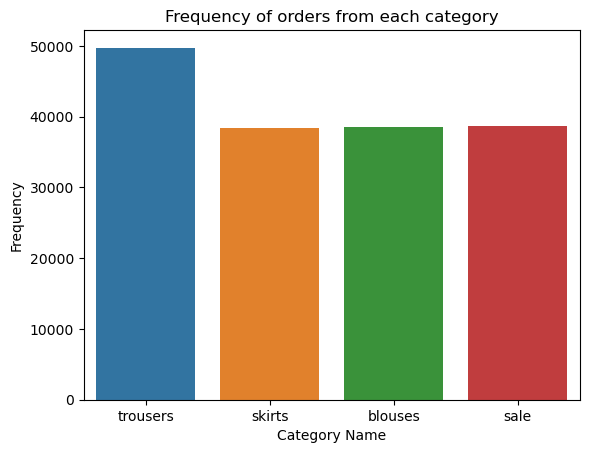

In [300]:
sns.countplot(x=catdata['category_name'])
plt.title(f'Frequency of orders from each category')
plt.ylabel('Frequency')
plt.xlabel('Category Name')
plt.show()

Clearly within the three months, users have shopped more for trousers, and rest of the product categories are browsed equally!<br><br>Understanding monthly orders from each product category will make us transperant to the categories popular each month.

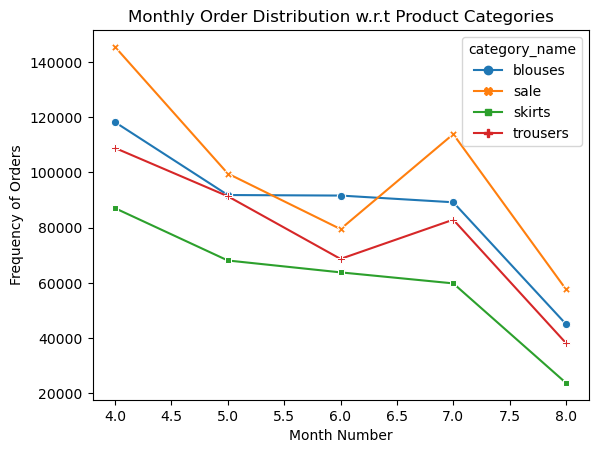

In [301]:
cat_monthly_orders = catdata.groupby(['month', 'category_name'])['order'].sum().reset_index()
sns.lineplot(data=cat_monthly_orders, x="month", y="order",
             hue="category_name", style="category_name",
             markers=True, dashes=False)
plt.title(f'Monthly Order Distribution w.r.t Product Categories')
plt.xlabel(f'Month Number')
plt.ylabel(f'Frequency of Orders')
plt.show()

Clearly, There seems to be a sale in the months of April & August. Though trousers have higher number of orders collectively, we find blouses have higher number of orders each month. Skirts have relatively less frequency of orders per month.

C:\Users\BharathRajPragada\AppData\Local\Temp\ipykernel_16680\2013358958.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



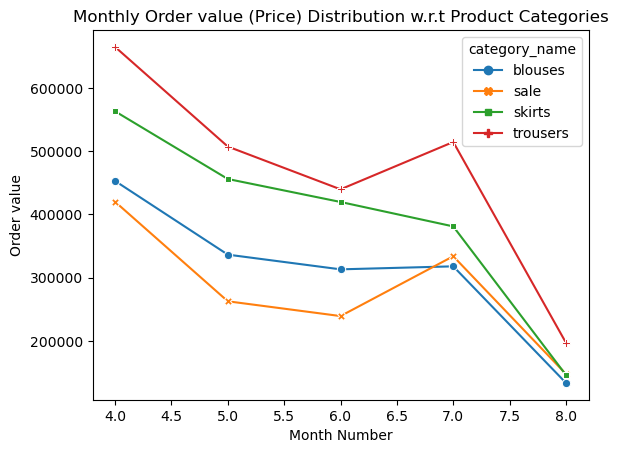

In [302]:
catdata = shopping_data[['category', 'price', 'month']]
catdata['category_name'] = catdata['category'].apply(lambda c: category_map.get(c))

cat_monthly_orders = catdata.groupby(['month', 'category_name'])['price'].sum().reset_index()
sns.lineplot(data=cat_monthly_orders, x="month", y="price",
             hue="category_name", style="category_name",
             markers=True, dashes=False)
plt.title(f'Monthly Order value (Price) Distribution w.r.t Product Categories')
plt.xlabel(f'Month Number')
plt.ylabel(f'Order value')
plt.show()

Trousers, though ordered less have higher price compared to rest of the categories. It is interesting to see, blouses having higher number of orders yet its price is lower than rest of the categories. This only goes to say blouses were actually priced less and hence more orders were placed. We can make similar explainations for rest of the categories.

#### Bivariate

##### Correlation Analysis:

Pearson's correlation helps in determining whether two attributes share same information or not

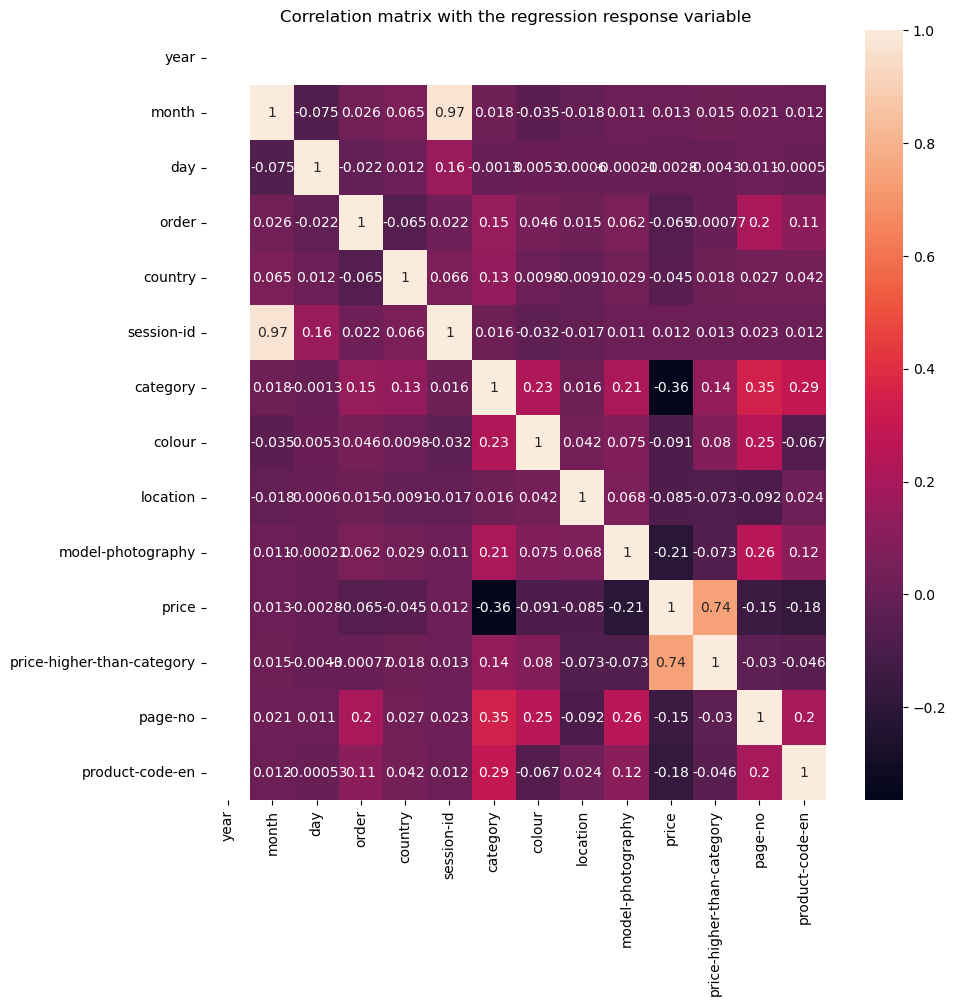

In [303]:
plt.figure(figsize=(10,10))
sns.heatmap(regression_data.corr(), annot=True)
plt.title(f'Correlation matrix with the regression response variable')
plt.show()

Observations:
- `year` attribute clearly isn't important.
- `month` strongly correlates with `session-id`, so we can remove one. Session IDs increase in value simply because each new session is a serial ID and hence as months increase, the every new user is alloted a new session ID with increasing order. Hence the correlation.
- `price` has a strong positive correlation with `price-higher-than-category`, hence we keep price and remove `price-higher-than-category`.

#### Regression Analysis

In [304]:
regression_data.isnull().sum()

year                          0
month                         0
day                           0
order                         0
country                       0
session-id                    0
category                      0
colour                        0
location                      0
model-photography             0
price                         0
price-higher-than-category    0
page-no                       0
product-code-en               0
dtype: int64

In [305]:
regression_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165464 entries, 0 to 165463
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   year                        165464 non-null  int64
 1   month                       165464 non-null  int64
 2   day                         165464 non-null  int64
 3   order                       165464 non-null  int64
 4   country                     165464 non-null  int64
 5   session-id                  165464 non-null  int64
 6   category                    165464 non-null  int64
 7   colour                      165464 non-null  int64
 8   location                    165464 non-null  int64
 9   model-photography           165464 non-null  int64
 10  price                       165464 non-null  int64
 11  price-higher-than-category  165464 non-null  int64
 12  page-no                     165464 non-null  int64
 13  product-code-en             165464 non-null 

In [306]:
X = sm.add_constant(regression_data.drop(['year',
                                          'price',
                                          'session-id',
                                          'price-higher-than-category'
                                          ], axis=1))
y = regression_data['price']



model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     3198.
Date:                Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:06:20   Log-Likelihood:            -6.3872e+05
No. Observations:              165464   AIC:                         1.277e+06
Df Residuals:                  165453   BIC:                         1.278e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                58.9276      0.19

Clearly, the attributes - `day`, `order`, `country`, `page-no`, are all having p-value higher than 0.05 (significance level). It means that we fail to reject the null hypothesis that the coefficients of these attributes are zero - thus implying these coefficients are not effective in predicting the price. Let's test this further by using `backward elimination` and checking the R2 score!

In [307]:
# Model a
X_a = X.drop(['day'], axis=1)
model_a = sm.OLS(y, X_a)
results_a = model_a.fit()

# Model b
X_b = X.drop(['day', 'order'], axis=1)
model_b = sm.OLS(y, X_b)
results_b = model_b.fit()

# Model c
X_c = X.drop(['day', 'order', 'country'], axis=1)
model_c = sm.OLS(y, X_c)
results_c = model_c.fit()

# Model d
X_d = X.drop(['day', 'order', 'country', 'page-no'], axis=1)
model_d = sm.OLS(y, X_d)
results_d = model_d.fit()

In [308]:
print(f'Model a R2: {results_a.rsquared_adj}')
print(f'Model b R2: {results_b.rsquared_adj}')
print(f'Model c R2: {results_c.rsquared_adj}')
print(f'Model d R2: {results_d.rsquared_adj}')

Model a R2: 0.16191613207257483
Model b R2: 0.16192094310220362
Model c R2: 0.16192426300760443
Model d R2: 0.16191942803013692


Hence with backward elemination, we show that the model's performance in capturing the variance is constant even by removing these attributes.

### Cleaned Data

In [309]:
cleaned_data = shopping_data.drop(['year', 'session-id', 'price-category_en', 'day', 'order', 'country', 'page-no'], axis=1)

In [310]:
cleaned_data.to_parquet('final-ecommerce-clothing-data.gzip', index=False)

In [311]:
print(f'Number of Final Attributes: {len(cleaned_data.columns)}')

Number of Final Attributes: 9


### RandomForestRegressor

In [312]:
from sklearn.ensemble import RandomForestRegressor

In [313]:
X_reg = regression_data.drop(['price', 'price-higher-than-category'], axis=1)
y_reg = regression_data['price']

In [314]:
rf = RandomForestRegressor()

rf.fit(X_reg,y_reg)

RandomForestRegressor()

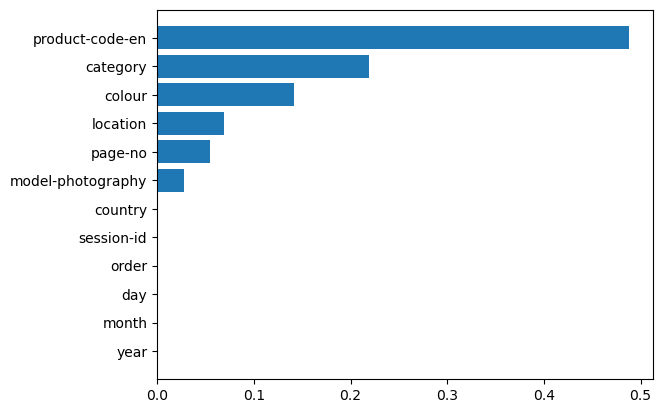

In [315]:
f_i = list(zip(X_reg.columns, rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

### Get the Data

### Import Packages

In [317]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor

### Data Preparation & Split

In [318]:
# data = pd.read_parquet('final-ecommerce-clothing-data.gzip')
shopping_data.drop(['year', 'session-id', 'day', 'order', 'country', 'page-no', 'price-higher-than-category','date'], axis=1, inplace=True)

shopping_data.head()

,month,category,colour,location,model-photography,price,product-code-en,price-category_en
0,4,1,1,5,1,28,0,0
1,4,1,1,6,1,33,1,0
2,4,2,10,2,1,52,2,1
3,4,2,6,6,2,38,3,1
4,4,2,4,3,2,52,4,1


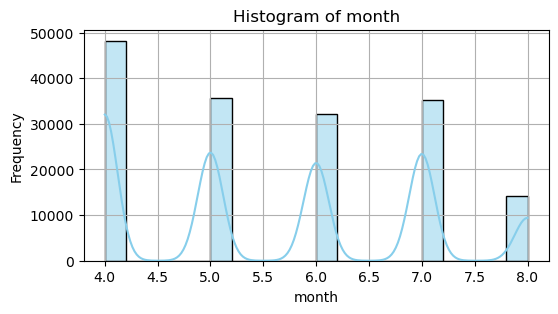

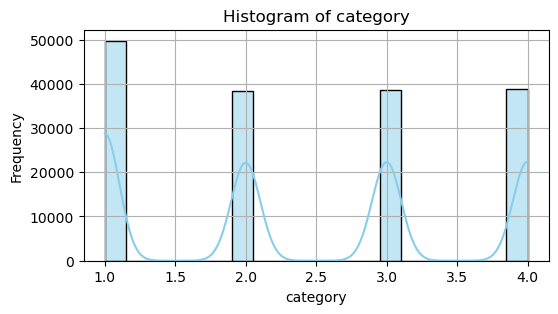

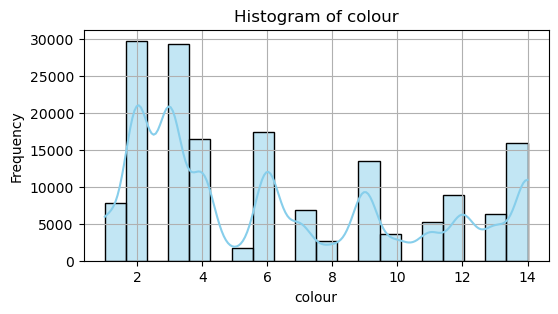

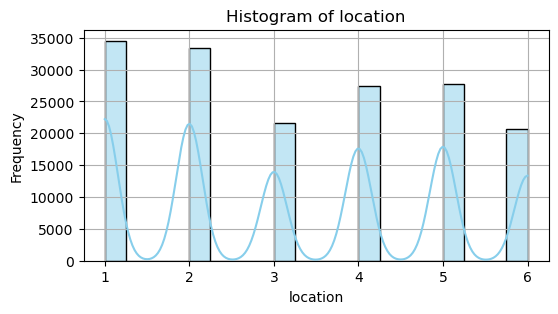

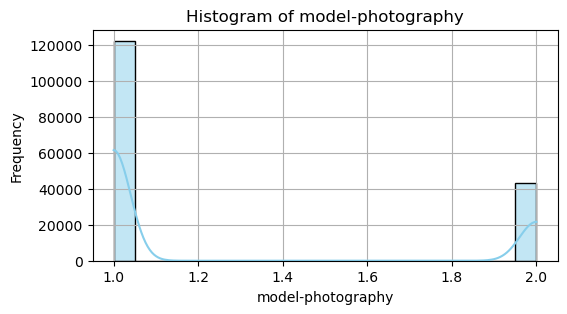

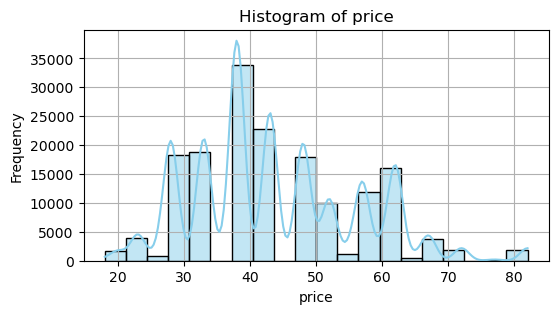

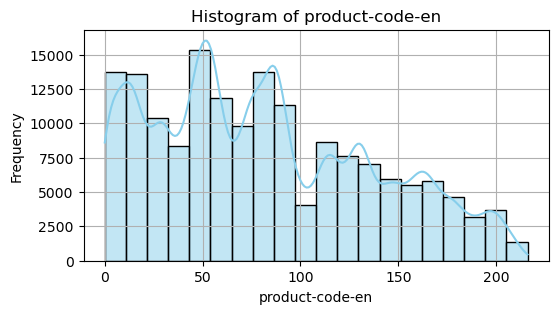

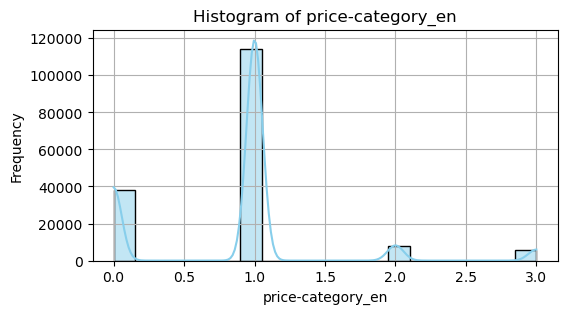

In [319]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your data is in a DataFrame called df
# Replace df with your actual DataFrame name

# Define the features you want to plot
features_to_plot = ['month', 'category', 'colour', 'location', 'model-photography', 'price','product-code-en', 'price-category_en']

# Plot histograms for each feature
for feature in features_to_plot:
    
    plt.figure(figsize=(6, 3))
    sns.histplot(data=shopping_data, x=feature, bins=20, kde=True, color='skyblue', edgecolor='black')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature}')
    plt.grid(True)
    plt.show()


In [320]:
regression_data = shopping_data.drop(['price-category_en'], axis=1)

In [321]:
train, test = train_test_split(regression_data, test_size=0.2, random_state=42)
X_train, y_train =  train.drop(['price'], axis=1), train['price']
X_test, y_test = test.drop(['price'], axis=1), test['price']
print(f'Train samples: {len(train)} & Test samples: {len(test)}')

Train samples: 132371 & Test samples: 33093


### Data Scaling

In [322]:
class StandardScalar:
  def fit(self, X: np.array) -> None:
    self._mean = np.mean(X, axis=0)
    self._std = np.std(X, axis=0)

  def transform(self, X: np.array) -> np.array:
    return (X - self._mean) / self._std

  def fit_transform(self, X: np.array) -> np.array:
    self.fit(X)
    return self.trasform(X)

In [323]:
std_scalar = StandardScalar()

In [324]:
std_scalar.fit(X_train)
X_train_std = std_scalar.transform(X_train)
X_test_std = std_scalar.transform(X_test)

In [325]:
print(f'Column means: Train - {np.round(np.mean(X_train_std, axis=0).values, 3)} & Test - {np.round(np.mean(X_test_std, axis=0), 3).values}')
print(f'Column standard deviations: Train - {np.std(X_train_std, axis=0).values} & Test - {np.std(X_test_std, axis=0).values}')

Column means: Train - [0.000000 -0.000000 0.000000 -0.000000 -0.000000 -0.000000] & Test - [0.006000 -0.002000 0.005000 0.003000 -0.001000 0.003000]
Column standard deviations: Train - [1.000000 1.000000 1.000000 1.000000 1.000000 1.000000] & Test - [0.997616 0.998903 1.002289 1.000203 0.999507 1.000505]


## Phase 3: Regression - Model Implementation and Baseline Evaluation 

In [326]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, RocCurveDisplay, recall_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt


# Linear Regressor

In [327]:
lr_sk = LinearRegression()
lr_sk.fit(X_train_std, y_train)
print(f'Intercept: {lr_sk.intercept_}\nCoefficients: {lr_sk.coef_}\nR2 score: {lr_sk.score(X_train_std, y_train)}')

Intercept: 43.793829464157554
Coefficients: [0.236922 -3.913020 -0.110039 -0.836593 -1.635989 -0.902554]
R2 score: 0.1605266557326246


# Ridge Regressor

In [328]:
ridge_sk = Ridge(alpha=10)
ridge_sk.fit(X_train_std, y_train)
print(f'Intercept: {ridge_sk.intercept_}\nCoefficients: {ridge_sk.coef_}\nR2 score: {ridge_sk.score(X_train_std, y_train)}')

Intercept: 43.793829464157554
Coefficients: [0.236897 -3.912712 -0.110112 -0.836535 -1.635925 -0.902588]
R2 score: 0.16052665509465425


# LASSO Regressor

In [329]:
lasso_sk = Lasso(alpha=10)
lasso_sk.fit(X_train_std, y_train)
print(f'Intercept: {lasso_sk.intercept_}\nCoefficients: {lasso_sk.coef_}\nR2 score: {lasso_sk.score(X_train_std, y_train)}')

Intercept: 43.793829464157554
Coefficients: [0.000000 -0.000000 -0.000000 -0.000000 -0.000000 -0.000000]
R2 score: 0.0


# KNN Regressor

In [330]:
# Initialize and fit KNN Regressor
knn = KNeighborsRegressor()
knn.fit(X_train_std, y_train)
knn_r2 = knn.score(X_train_std, y_train)

# Decision Tree Regressor

In [331]:
# Initialize and fit Decision Tree Regressor
dt = DecisionTreeRegressor()
dt.fit(X_train_std, y_train)
dt_r2 = dt.score(X_train_std, y_train)

# Bagging Regressor

In [332]:
# Initialize and fit Bagging Regressor
bagging = BaggingRegressor()
bagging.fit(X_train_std, y_train)
bagging_r2 = bagging.score(X_train_std, y_train)

# Random Forest Regressor

In [333]:
# Initialize and fit Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(X_train_std, y_train)
rf_r2 = rf.score(X_train_std, y_train)

# Neural Network Regressor

In [334]:
# Initialize and fit Neural Network Regressor
nn = MLPRegressor()
nn.fit(X_train_std, y_train)
nn_r2 = nn.score(X_train_std, y_train)

C:\Users\BharathRajPragada\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [335]:
print(f'KNN Regressor R2 score: {knn_r2}')
print(f'Decision Tree Regressor R2 score: {dt_r2}')
print(f'Random Forest Regressor R2 score: {rf_r2}')
print(f'Bagging Regressor R2 score: {bagging_r2}')
print(f'Neural Network Regressor R2 score: {nn_r2}')

KNN Regressor R2 score: 0.9999814034218897
Decision Tree Regressor R2 score: 1.0
Random Forest Regressor R2 score: 0.9999988075782057
Bagging Regressor R2 score: 0.9999967769911488
Neural Network Regressor R2 score: 0.8945006323965328


In [336]:
y_preds_lr_sk = lr_sk.predict(X_test_std)
y_preds_rlr_sk = ridge_sk.predict(X_test_std)
y_preds_llr_sk = lasso_sk.predict(X_test_std)
y_preds_knn = knn.predict(X_test_std)
y_preds_dt = dt.predict(X_test_std)
y_preds_bagging = bagging.predict(X_test_std)
y_preds_rf = rf.predict(X_test_std)
y_preds_nn = nn.predict(X_test_std)

In [337]:
@dataclass
class RegressionEvaluation:
  y_true: np.array
  y_predictions: np.array
  model_name: str

  def _get_residuals(self) -> None:
    self._residuals = self.y_true - self.y_predictions

  def _get_sse(self) -> None:
    self._sse = np.sum(self._residuals ** 2)

  def _get_mse(self) -> None:
    self._mse = self._sse / self._num_samples

  def _get_rmse(self) -> None:
    self._rmse = np.sqrt(self._mse)

  def _get_r2(self) -> None:
    y_bar = np.mean(self.y_true)
    SST = np.sum((self.y_true - y_bar)**2)
    SSE = self._sse
    self._r2 = 1 - (SSE / SST)

  def results(self) -> str:
    self._num_samples = len(self.y_true)
    self._get_residuals()
    self._get_sse()
    self._get_mse()
    self._get_rmse()
    self._get_r2()

    return f'''Model Name: {self.model_name}\n\nMSE: {self._mse}\nRMSE: {self._rmse}\nR2: {self._r2}\n\n'''

In [338]:
print(RegressionEvaluation(y_test, y_preds_lr_sk, 'Sk Linear Regression').results())
print(RegressionEvaluation(y_test, y_preds_rlr_sk, 'Sk Ridge Linear Regression').results())
print(RegressionEvaluation(y_test, y_preds_llr_sk, 'Sk Lasso Linear Regression').results())
print(RegressionEvaluation(y_test, y_preds_knn, 'Sk KNN Regression').results())
print(RegressionEvaluation(y_test, y_preds_dt, 'Sk Decision Tree Regression').results())
print(RegressionEvaluation(y_test, y_preds_bagging, 'Sk Bagging Regression').results())
print(RegressionEvaluation(y_test, y_preds_rf, 'Sk Random Forest Regression').results())
print(RegressionEvaluation(y_test, y_preds_nn, 'Sk Neural Network Regression').results())

Model Name: Sk Linear Regression

MSE: 132.91989161662835
RMSE: 11.529088932635933
R2: 0.16747596662357034


Model Name: Sk Ridge Linear Regression

MSE: 132.9199709130501
RMSE: 11.529092371607147
R2: 0.16747546996218976


Model Name: Sk Lasso Linear Regression

MSE: 159.66079623885835
RMSE: 12.635695320751381
R2: -1.1724657757117285e-05


Model Name: Sk KNN Regression

MSE: 0.0007856646420693198
RMSE: 0.02802970998903342
R2: 0.9999950791060033


Model Name: Sk Decision Tree Regression

MSE: 0.0
RMSE: 0.0
R2: 1.0


Model Name: Sk Bagging Regression

MSE: 0.00010908651376424
RMSE: 0.010444448944977423
R2: 0.9999993167527951


Model Name: Sk Random Forest Regression

MSE: 5.3452391744477544e-05
RMSE: 0.0073111142614841924
R2: 0.9999996652088696


Model Name: Sk Neural Network Regression

MSE: 17.18390888037176
RMSE: 4.1453478599958
R2: 0.892371134551313




# Phase 4: Regression - Hyperparameter Tuning

In [339]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error



# Creating a pipeline with multiple regressors
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GridSearchCV(estimator=DecisionTreeRegressor(),
                               param_grid={'max_depth': [3, 5, 7, 10],
                                           'min_samples_split': [2, 5, 10],
                                           'min_samples_leaf': [1, 2, 4]},
                               scoring='neg_mean_squared_error', cv=5, return_train_score=True))
])

# Fit Pipeline to the training data
pipeline.fit(X_train_std, y_train)

# Re-evaluate model with tuned hyperparameters
best_regressor = pipeline.named_steps['regressor'].best_estimator_
y_pred = best_regressor.predict(X_test_std)
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error after Hyperparameter Tuning:", mse)

Mean Squared Error after Hyperparameter Tuning: 24.38133892046599


C:\Users\BharathRajPragada\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names



### Downloading the Best Regression Model for Deployment

In [340]:
from joblib import dump
# Assuming best_regressor is your trained regressor
dump(best_regressor, 'regressor_model.joblib')

['regressor_model.joblib']

## Phase 3: Classification - Model Implementation and Baseline Evaluation 

### Import Packages

In [341]:
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union
from scipy import stats
import seaborn as sns
from collections import Counter
from dataclasses import dataclass
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import multivariate_normal


np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [342]:
# data = pd.read_csv('/content/ecommerce-clothing-data.gzip')
classification_data.drop([
    'year', 'session-id', 'day', 'order', 'country',
    'page-no', 'price-higher-than-category'
], axis=1, inplace=True)

In [343]:
classification_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165464 entries, 0 to 165463
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   month              165464 non-null  int64
 1   category           165464 non-null  int64
 2   colour             165464 non-null  int64
 3   location           165464 non-null  int64
 4   model-photography  165464 non-null  int64
 5   product-code-en    165464 non-null  int32
 6   price-category_en  165464 non-null  int32
dtypes: int32(2), int64(5)
memory usage: 7.6 MB


In [344]:
train, test = train_test_split(classification_data, test_size=0.2, stratify=classification_data['price-category_en'], random_state=42)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

X_train, y_train =  train.drop(['price-category_en'], axis=1), train['price-category_en']
X_test, y_test = test.drop(['price-category_en'], axis=1), test['price-category_en']
print(f'Train samples: {len(train)} & Test samples: {len(test)}')

Train samples: 132371 & Test samples: 33093


Drop the duplicates and make a dataset with only unique records, as this will be needed for KNN classifier

In [345]:
unique_data = classification_data.drop_duplicates()

In [346]:
utrain, utest = train_test_split(unique_data, test_size=0.15, stratify=unique_data['price-category_en'],random_state=42)
utrain.reset_index(drop=True, inplace=True)
utest.reset_index(drop=True, inplace=True)

uX_train, uy_train =  utrain.drop(['price-category_en'], axis=1), utrain['price-category_en']
uX_test, uy_test = utest.drop(['price-category_en'], axis=1), utest['price-category_en']
print(f'Unique Train samples: {len(utrain)} & Unique Test samples: {len(utest)}')

Unique Train samples: 910 & Unique Test samples: 161


## Data Preprocessing

In [347]:
class StandardScalar:
  def fit(self, X: np.array) -> None:
    self._mean = np.mean(X, axis=0)
    self._std = np.std(X, axis=0)

  def transform(self, X: np.array) -> np.array:
    return (X - self._mean) / self._std

  def fit_transform(self, X: np.array) -> np.array:
    self.fit(X)
    return self.trasform(X)

In [348]:
std_scalar = StandardScalar()

In [349]:
std_scalar.fit(X_train)
X_train_std = std_scalar.transform(X_train)
X_test_std = std_scalar.transform(X_test)

In [350]:
print(f'Column means: Train - {np.round(np.mean(X_train_std, axis=0).values, 3)} & Test - {np.round(np.mean(X_test_std, axis=0), 3).values}')
print(f'Column standard deviations: Train - {np.std(X_train_std, axis=0).values} & Test - {np.std(X_test_std, axis=0).values}')

Column means: Train - [-0.000000 0.000000 0.000000 -0.000000 0.000000 0.000000] & Test - [-0.001000 -0.008000 -0.001000 0.003000 0.009000 -0.009000]
Column standard deviations: Train - [1.000000 1.000000 1.000000 1.000000 1.000000 1.000000] & Test - [1.005433 0.997359 0.999757 1.005124 1.004757 0.995586]


In [351]:
assert len(X_train_std) == len(y_train), 'Samples in X train & y train don`t match'
assert len(X_test_std) == len(y_test), 'Samples in X test & y test don`t match'

In [352]:
ustd_scalar = StandardScalar()
ustd_scalar.fit(uX_train)
uX_train_std = ustd_scalar.transform(uX_train)
uX_test_std = ustd_scalar.transform(uX_test)

In [353]:
class OneHotEncoding:

  def fit(self, y: np.array) -> None:
    self.unique_classes = np.sort(np.unique(y))
    self.num_samples = len(y)

  def transform(self, y: np.array) -> np.array:

    onehots = np.zeros((self.num_samples, len(self.unique_classes)), dtype=int)
    for c in self.unique_classes:
      idx = np.where(y == c)
      onehots[:, c][idx] = 1
    return onehots

  def fit_transform(self, y: np.array) -> np.array:
    self.fit(y)
    return self.transform(y)

In [354]:
onehot = OneHotEncoding()
onehot.fit(y_train)

In [355]:
y_train_onehot = onehot.transform(y_train)
y_test_onehot = onehot.transform(y_test)

In [356]:
scores = []
k_values = list(range(1, 11))

for k in k_values:
    print(f'k: {k}')
    knn = KNeighborsClassifier(k)
    knn.fit(uX_train_std, uy_train)
    preds = knn.predict(uX_test_std)
    scores.append(f1_score(uy_test, preds, average='weighted'))

k: 1
k: 2
k: 3
k: 4
k: 5
k: 6
k: 7
k: 8
k: 9
k: 10


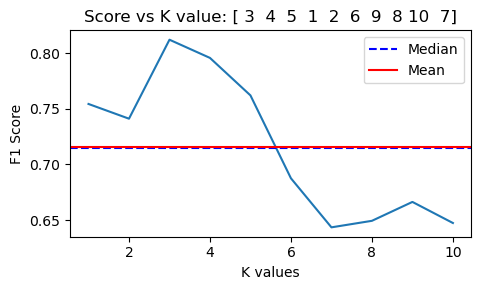

In [357]:
plt.figure(figsize=(5, 3))
sns.lineplot(x=k_values, y=scores)
plt.axhline(y=np.median(scores), linestyle='--', label=f'Median', color='blue')
plt.axhline(y=np.mean(scores), linestyle='-', label='Mean', color='red')
k_vals = np.array(k_values)
plt.title(f'Score vs K value: {k_vals[np.flip(np.argsort(scores))]}')
plt.xlabel(f'K values')
plt.ylabel(f'F1 Score')
plt.legend()
plt.tight_layout()
plt.show()

#### K-Nearest Neighbours

`NOTE`: Sklearn uses KDTree to do the approximate nearest neigbour search. Hence the Numpy Varient that uses pairwise euclidean distance cannot match or beat SKlearn's performance!

In [358]:
sk_lr = LogisticRegression().fit(X_train_std, y_train)
y_hats = sk_lr.predict(X_test_std)
print(classification_report(y_test, y_hats))

              precision    recall  f1-score   support

           0       0.46      0.10      0.16      7570
           1       0.70      0.96      0.81     22812
           2       0.00      0.00      0.00      1570
           3       0.00      0.00      0.00      1141

    accuracy                           0.69     33093
   macro avg       0.29      0.27      0.24     33093
weighted avg       0.59      0.69      0.60     33093



C:\Users\BharathRajPragada\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\BharathRajPragada\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\BharathRajPragada\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [359]:
neigh = KNeighborsClassifier()
neigh.fit(X_train_std, y_train)
y_preds = neigh.predict(X_test_std)
y_preds = neigh.predict(X_test_std)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7570
           1       1.00      1.00      1.00     22812
           2       1.00      1.00      1.00      1570
           3       1.00      1.00      1.00      1141

    accuracy                           1.00     33093
   macro avg       1.00      1.00      1.00     33093
weighted avg       1.00      1.00      1.00     33093



In [360]:
neigh.algorithm

'auto'

In [361]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7570
           1       1.00      1.00      1.00     22812
           2       1.00      1.00      1.00      1570
           3       1.00      1.00      1.00      1141

    accuracy                           1.00     33093
   macro avg       1.00      1.00      1.00     33093
weighted avg       1.00      1.00      1.00     33093



In [362]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Define classifiers without hyperparameter tuning
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Bagging': BaggingClassifier(),
    'Neural Network': MLPClassifier()
}

# Train and predict with each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report for {name}:\n{report}\n")

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7570
           1       1.00      1.00      1.00     22812
           2       1.00      1.00      1.00      1570
           3       1.00      1.00      1.00      1141

    accuracy                           1.00     33093
   macro avg       1.00      1.00      1.00     33093
weighted avg       1.00      1.00      1.00     33093


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7570
           1       1.00      1.00      1.00     22812
           2       1.00      1.00      1.00      1570
           3       1.00      1.00      1.00      1141

    accuracy                           1.00     33093
   macro avg       1.00      1.00      1.00     33093
weighted avg       1.00      1.00      1.00     33093


Classification Report for Bagging:
           

C:\Users\BharathRajPragada\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Classification Report for Neural Network:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7570
           1       1.00      1.00      1.00     22812
           2       1.00      1.00      1.00      1570
           3       1.00      1.00      1.00      1141

    accuracy                           1.00     33093
   macro avg       1.00      1.00      1.00     33093
weighted avg       1.00      1.00      1.00     33093




# Classification - Hyperparameter Tuning

In [363]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score

# # Example dataset loading (replace with your own data)
# # df = pd.read_csv('your_data.csv')

# # Splitting the data into training and testing sets
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  


# # Creating a pipeline with multiple classifiers
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', GridSearchCV(estimator=LogisticRegression(max_iter=10000),param_grid = {
#     'logreg__C': np.logspace(-4, 4, 20),
#     'logreg__penalty': ['l1', 'l2'],
#     'logreg__solver': ['liblinear']  # 'liblinear' works well with both l1 and l2
# },scoring='accuracy', cv=2, return_train_score=True))
# ])


# # Parameters for GridSearchCV


# # Fit Pipeline to the training data
# pipeline.fit(X_train_std, y_train)

# # Re-evaluate model with tuned hyperparameters
# best_classifier = pipeline.named_steps['classifier'].best_estimator_
# y_pred = best_classifier.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# print("Accuracy after Hyperparameter Tuning:", accuracy)


In [364]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.metrics import accuracy_score

# # Example dataset loading (replace with your own data)
# # df = pd.read_csv('your_data.csv')

# # Splitting the data into training and testing sets
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Creating a pipeline with multiple classifiers
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('classifier', GridSearchCV(estimator=RandomForestClassifier(),
#                                 param_grid={'n_estimators': [50, 100, 200],
#                                             'max_depth': [5, 10, 20],
#                                             'min_samples_split': [2, 5, 10],
#                                             'min_samples_leaf': [1, 2, 4]},
#                                 scoring='accuracy', cv=5, return_train_score=True))
# ])

# # Fit Pipeline to the training data
# pipeline.fit(X_train_std, y_train)

# # Re-evaluate model with tuned hyperparameters
# best_classifier = pipeline.named_steps['classifier'].best_estimator_
# y_pred = best_classifier.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)

# print("Accuracy after Hyperparameter Tuning:", accuracy)


# Phase 5: Model Evaluation and Comparative Analysis

Performed in the above steps using r_2 score, MSE for Regression and Classification metrics for Classification

In [366]:
from joblib import dump
# Assuming best_classifier is your trained regressor
dump(classifiers['Neural Network'], 'classification_model.joblib')

['classification_model.joblib']

In [367]:
classifiers['Neural Network'].predict([[4,1,10,2,1,2]])

C:\Users\BharathRajPragada\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



array([1])

# Phase 6: Conclusion and Recommendations

In [368]:
best_regressor.predict([[4,1,1,5,1,0]])

array([33.000000])